In [1]:
"""
Data loader module for DATSCAN DICOM images.
This module provides functionality to load and preprocess DATSCAN images
for the Parkinson's Disease analysis project.
"""

import os
from pathlib import Path
from typing import List, Dict, Optional, Tuple, Union
import logging
from dataclasses import dataclass

import numpy as np
import pydicom
import torch
from torch.utils.data import Dataset

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class DATSCANMetadata:
    """Data class to store relevant DICOM metadata."""
    patient_id: str
    exam_date: str
    exam_id: str
    image_shape: Tuple[int, ...]
    pixel_spacing: Optional[Tuple[float, ...]] = None
    
class DATSCANDataLoader:
    """Class to handle loading and preprocessing of DATSCAN DICOM images."""
    
    def __init__(self, base_path: Union[str, Path], use_gpu: bool = True):
        """
        Initialize the data loader.
        
        Args:
            base_path: Root directory containing the DATSCAN images
            use_gpu: Whether to use GPU for processing (if available)
        """
        self.base_path = Path(base_path)
        self.device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
        self.dicom_paths: List[Path] = []
        self.metadata: Dict[str, DATSCANMetadata] = {}
        
    def find_dicom_files(self) -> None:
        """
        Recursively traverse directory structure to find all DICOM files.
        Updates self.dicom_paths with found files.
        """
        logger.info(f"Searching for DICOM files in {self.base_path}")
        try:
            for root, _, files in os.walk(self.base_path):
                for file in files:
                    if file.endswith('.dcm'):
                        path = Path(root) / file
                        self.dicom_paths.append(path)
            
            logger.info(f"Found {len(self.dicom_paths)} DICOM files")
        except Exception as e:
            logger.error(f"Error while searching for DICOM files: {str(e)}")
            raise
            
    def load_single_dicom(self, path: Path) -> Tuple[np.ndarray, DATSCANMetadata]:
        """
        Load a single DICOM file and extract relevant metadata.
        
        Args:
            path: Path to the DICOM file
            
        Returns:
            Tuple containing:
                - np.ndarray: The image data
                - DATSCANMetadata: Associated metadata
        """
        try:
            dcm = pydicom.dcmread(path)
            
            # Extract image data
            image_data = dcm.pixel_array.astype(float)
            
            # Extract metadata
            patient_id = str(path).split(os.sep)[3]  # Based on folder structure
            exam_date = str(path).split(os.sep)[5]   # Based on folder structure
            exam_id = str(path).split(os.sep)[6]     # Based on folder structure
            
            metadata = DATSCANMetadata(
                patient_id=patient_id,
                exam_date=exam_date,
                exam_id=exam_id,
                image_shape=image_data.shape,
                pixel_spacing=tuple(float(x) for x in dcm.PixelSpacing) if hasattr(dcm, 'PixelSpacing') else None
            )
            
            return image_data, metadata
            
        except Exception as e:
            logger.error(f"Error loading DICOM file {path}: {str(e)}")
            raise
            
    def load_all_data(self) -> Tuple[List[np.ndarray], Dict[str, DATSCANMetadata]]:
        """
        Load all DICOM files found in the directory structure.
        
        Returns:
            Tuple containing:
                - List of image arrays
                - Dictionary mapping file paths to metadata
        """
        if not self.dicom_paths:
            self.find_dicom_files()
            
        images = []
        metadata_dict = {}
        
        for path in self.dicom_paths:
            try:
                image, metadata = self.load_single_dicom(path)
                images.append(image)
                metadata_dict[str(path)] = metadata
            except Exception as e:
                logger.warning(f"Skipping file {path} due to error: {str(e)}")
                continue
                
        return images, metadata_dict

class DATSCANDataset(Dataset):
    """PyTorch Dataset class for DATSCAN images."""
    
    def __init__(self, base_path: Union[str, Path], transform=None):
        """
        Initialize the dataset.
        
        Args:
            base_path: Root directory containing the DATSCAN images
            transform: Optional transform to be applied to the images
        """
        self.loader = DATSCANDataLoader(base_path)
        self.transform = transform
        self.images, self.metadata = self.loader.load_all_data()
        
    def __len__(self) -> int:
        return len(self.images)
        
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, DATSCANMetadata]:
        """
        Get a single item from the dataset.
        
        Args:
            idx: Index of the item to retrieve
            
        Returns:
            Tuple containing:
                - torch.Tensor: The image data
                - DATSCANMetadata: Associated metadata
        """
        image = self.images[idx]
        metadata = list(self.metadata.values())[idx]
        
        # Convert to torch tensor
        image_tensor = torch.from_numpy(image).float()
        
        if self.transform:
            image_tensor = self.transform(image_tensor)
            
        return image_tensor, metadata

def main():
    """Example usage of the data loader."""
    # Example path - replace with actual path
    base_path = Path("Images_Test/dicom")
    
    # Initialize data loader
    loader = DATSCANDataLoader(base_path)
    
    # Find all DICOM files
    loader.find_dicom_files()
    
    # Load all data
    images, metadata = loader.load_all_data()
    
    # Print summary
    logger.info(f"Loaded {len(images)} images")
    logger.info(f"First image shape: {images[0].shape}")
    
if __name__ == "__main__":
    main()

INFO:__main__:Searching for DICOM files in Images_Test\dicom
INFO:__main__:Found 6 DICOM files
INFO:__main__:Loaded 6 images
INFO:__main__:First image shape: (91, 109, 91)


In [10]:
"""
Following cell should be run after the data loading cell
"""

# Import from previous cell
from typing import List
from pathlib import Path
from data_loader import DATSCANDataLoader  # Assuming the previous cell defined this class

import torch
import torch.nn.functional as F
from typing import Optional, Tuple, Union
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
# Try to use notebook progress bar, fall back to regular tqdm if not available
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

class DATSCANPreprocessor:
    """Class to handle preprocessing of DATSCAN images."""
    
    def __init__(self, device: Optional[torch.device] = None):
        """
        Initialize the preprocessor.
        
        Args:
            device: torch.device to use for computation
        """
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.scaler = StandardScaler()
        
    def normalize_intensity(self, image: torch.Tensor, method: str = 'z_score') -> torch.Tensor:
        """
        Normalize image intensity using specified method.
        
        Args:
            image: Input image tensor
            method: Normalization method ('z_score', 'min_max', or 'percentile')
            
        Returns:
            Normalized image tensor
        """
        if method == 'z_score':
            # Compute mean and std on flattened tensor
            mean = image.mean()
            std = image.std()
            normalized = (image - mean) / (std + 1e-8)
            
        elif method == 'min_max':
            min_val = image.min()
            max_val = image.max()
            normalized = (image - min_val) / (max_val - min_val + 1e-8)
            
        elif method == 'percentile':
            # Use percentiles to be more robust to outliers
            p_low = torch.quantile(image, 0.01)
            p_high = torch.quantile(image, 0.99)
            normalized = torch.clamp((image - p_low) / (p_high - p_low + 1e-8), 0, 1)
            
        else:
            raise ValueError(f"Unknown normalization method: {method}")
            
        return normalized
        
    def resize_volume(self, image: torch.Tensor, target_size: Tuple[int, ...]) -> torch.Tensor:
        """
        Resize image to target dimensions using trilinear interpolation.
        
        Args:
            image: Input image tensor (should be 3D)
            target_size: Desired output size
            
        Returns:
            Resized image tensor
        """
        # Add batch and channel dimensions for F.interpolate
        if image.dim() == 3:
            image = image.unsqueeze(0).unsqueeze(0)
            
        resized = F.interpolate(image, size=target_size, mode='trilinear', align_corners=False)
        
        # Remove batch and channel dimensions
        return resized.squeeze(0).squeeze(0)
        
    def create_brain_mask(self, image: torch.Tensor, threshold: float = 0.1) -> torch.Tensor:
        """
        Create a binary mask for brain region based on intensity thresholding.
        
        Args:
            image: Input image tensor
            threshold: Threshold value for binary mask (relative to max intensity)
            
        Returns:
            Binary mask tensor
        """
        # Normalize image to 0-1 range for thresholding
        normalized = self.normalize_intensity(image, method='min_max')
        
        # Create binary mask
        mask = (normalized > threshold).float()
        
        # Apply morphological operations to clean up the mask
        kernel_size = 3
        kernel = torch.ones(1, 1, kernel_size, kernel_size, kernel_size).to(self.device)
        
        # Add dimensions for conv3d
        mask = mask.unsqueeze(0).unsqueeze(0)
        
        # Closing operation (dilation followed by erosion)
        mask = F.conv3d(mask, kernel, padding=kernel_size//2) > 0
        mask = F.conv3d(mask.float(), kernel, padding=kernel_size//2) >= kernel.sum()
        
        return mask.squeeze(0).squeeze(0)
        
    def apply_mask(self, image: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        Apply binary mask to image.
        
        Args:
            image: Input image tensor
            mask: Binary mask tensor
            
        Returns:
            Masked image tensor
        """
        return image * mask
        
    def preprocess_single_image(self, 
                              image: torch.Tensor,
                              target_size: Optional[Tuple[int, ...]] = None,
                              normalize_method: str = 'z_score',
                              apply_brain_mask: bool = True) -> torch.Tensor:
        """
        Apply full preprocessing pipeline to single image.
        
        Args:
            image: Input image tensor
            target_size: Optional target size for resizing
            normalize_method: Method for intensity normalization
            apply_brain_mask: Whether to apply brain masking
            
        Returns:
            Preprocessed image tensor
        """
        # Move to device
        image = image.to(self.device)
        
        # Resize if target size is specified
        if target_size is not None:
            image = self.resize_volume(image, target_size)
            
        # Create and apply brain mask if requested
        if apply_brain_mask:
            mask = self.create_brain_mask(image)
            image = self.apply_mask(image, mask)
            
        # Normalize intensity
        image = self.normalize_intensity(image, method=normalize_method)
        
        return image
        
    def preprocess_batch(self, 
                        images: List[torch.Tensor],
                        target_size: Optional[Tuple[int, ...]] = None,
                        normalize_method: str = 'z_score',
                        apply_brain_mask: bool = True) -> List[torch.Tensor]:
        """
        Apply preprocessing to a batch of images.
        
        Args:
            images: List of input image tensors
            target_size: Optional target size for resizing
            normalize_method: Method for intensity normalization
            apply_brain_mask: Whether to apply brain masking
            
        Returns:
            List of preprocessed image tensors
        """
        preprocessed_images = []
        
        try:
            iterator = tqdm(images, desc="Preprocessing images")
        except Exception:
            # Fall back to regular iteration if tqdm fails
            print("Processing images...")
            iterator = images
            
        for image in iterator:
            preprocessed = self.preprocess_single_image(
                image,
                target_size=target_size,
                normalize_method=normalize_method,
                apply_brain_mask=apply_brain_mask
            )
            preprocessed_images.append(preprocessed)
            
        return preprocessed_images
        
    def visualize_preprocessing(self, 
                              original_image: torch.Tensor,
                              preprocessed_image: torch.Tensor,
                              slice_idx: Optional[int] = None):
        """
        Visualize original and preprocessed images side by side.
        
        Args:
            original_image: Original image tensor
            preprocessed_image: Preprocessed image tensor
            slice_idx: Index of slice to visualize (if None, uses middle slice)
        """
        if slice_idx is None:
            slice_idx = original_image.shape[0] // 2
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        
        # Plot original image
        ax1.imshow(original_image[slice_idx].cpu().numpy(), cmap='gray')
        ax1.set_title('Original Image')
        ax1.axis('off')
        
        # Plot preprocessed image
        ax2.imshow(preprocessed_image[slice_idx].cpu().numpy(), cmap='gray')
        ax2.set_title('Preprocessed Image')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()

# Example usage
def preprocess_example(base_path: str = "Images_Test/dicom"):
    """
    Example function demonstrating the preprocessing pipeline.
    
    Args:
        base_path: Path to the directory containing DICOM files
    
    Returns:
        Tuple of (preprocessed_images, metadata)
    """
    # Load images using DATSCANDataLoader
    loader = DATSCANDataLoader(base_path)
    images, metadata = loader.load_all_data()
    
    # Convert to torch tensors
    image_tensors = [torch.from_numpy(img).float() for img in images]
    
    # Initialize preprocessor
    preprocessor = DATSCANPreprocessor()
    
    # Define target size (example dimensions)
    target_size = (128, 128, 128)
    
    # Preprocess images
    preprocessed_images = preprocessor.preprocess_batch(
        image_tensors,
        target_size=target_size,
        normalize_method='z_score',
        apply_brain_mask=True
    )
    
    # Visualize first image before and after preprocessing
    preprocessor.visualize_preprocessing(image_tensors[0], preprocessed_images[0])
    
    return preprocessed_images, metadata

# Run example if needed
# preprocessed_images, metadata = preprocess_example()

INFO:data_loader:Searching for DICOM files in Images_Test\dicom
INFO:data_loader:Found 6 DICOM files
Exception ignored in: <function tqdm.__del__ at 0x00000285ADCED260>
Traceback (most recent call last):
  File "c:\Users\alexc\Local Github\ParkinsonThesis\.venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\alexc\Local Github\ParkinsonThesis\.venv\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Processing images...


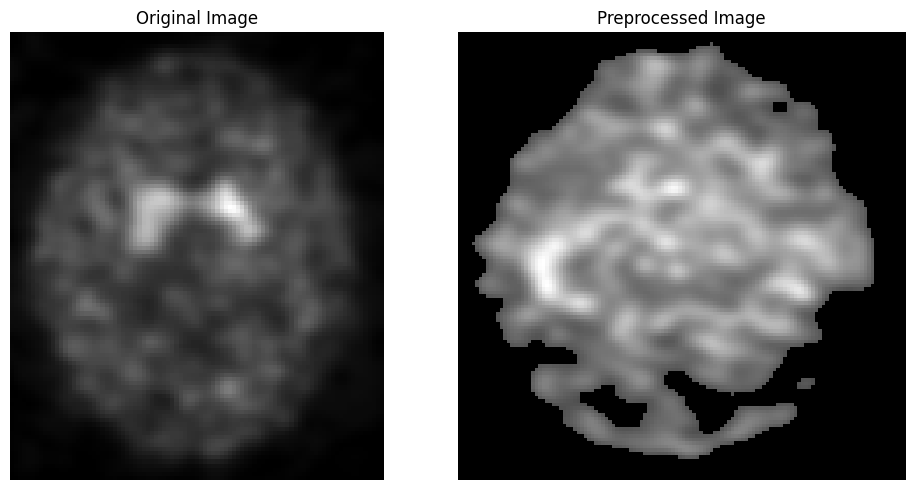

In [11]:
preprocessed_images, metadata = preprocess_example()

In [9]:
%pip install ipywidgets

   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------- ----------------- 1.3/2.3 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 6.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
